In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install interpret shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.5 MB/s 
     |████████████████████████████████| 8.9 MB 6.4 MB/s 
     |████████████████████████████████| 275 kB 50.5 MB/s 
     |████████████████████████████████| 280 kB 49.8 MB/s 
     |████████████████████████████████| 758 kB 45.3 MB/s 
     |████████████████████████████████| 3.6 MB 10.2 MB/s 
     |████████████████████████████████| 6.5 MB 45.9 MB/s 
     |████████████████████████████████| 9.9 MB 47.6 MB/s 
     |████████████████████████████████| 261 kB 47.5 MB/s 
     |████████████████████████████████| 1.6 MB 11.5 MB/s 
     |████████████████████████████████| 132 kB 65.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=050a094c4be2b79d25a08fd3f3e820107d2615787b8f742dbb2568f992e55a28
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfu

In [ ]:
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import xgboost

import shap
from shap import TreeExplainer

from interpret.glassbox import ExplainableBoostingClassifier

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SequentialFeatureSelector, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split

pd.pandas.set_option('display.max_columns',None)

In [ ]:
data = pd.read_csv('/content/drive/My Drive/data01.csv')
data.columns = data.columns.str.replace(' ', '_')

# We don't need the group and ID in our model
data = data.drop(columns=['group', 'ID'], axis=1)


In [ ]:
categorical_features = [features for features in data.columns if len(data[features].unique()) <= 5]
numerical_features = data.columns[~data.columns.isin(categorical_features)].tolist()
for feat in categorical_features:
    data[feat] = data[feat].astype('category')
for i in numerical_features:
    if data[i].isnull().any():
        data[i]=data[i].fillna(data[i].mean())
data = data.dropna(how='any', axis=0)

In [ ]:

# Getting our features and target to build the model
features = data.drop(columns='outcome').copy()
target = data['outcome'].copy()

x_train , x_test , y_train , y_test = train_test_split(features,target,stratify=target,test_size=0.2,random_state=2)
#x_train, y_train=resample(x_train,y_train)

In [ ]:
def resample(x_train,y_train):
  #print(len(x_train))
  positive_data=pd.DataFrame(columns=x_train.columns)
  for i in range(len(y_train)):
    if y_train.iloc[i]==1:
      positive_data=positive_data.append(x_train.iloc[i])

  total_positive_samples_train=len(positive_data)
  #print('total positive samples in the train set',total_positive_samples_train)
  total_negative_samples_train=len(y_train)-total_positive_samples_train
  #print('total negative samples in the train set',total_negative_samples_train)
  samples_needed_to_balance=total_negative_samples_train - total_positive_samples_train
  extra_positive_sampled_data=positive_data.sample(n=samples_needed_to_balance,replace=True)
  final_x_train=pd.concat([x_train,extra_positive_sampled_data],axis=0)

  extra_target=pd.Series([1 for i in range(samples_needed_to_balance)])
  final_y_train=y_train.append(extra_target)

  return final_x_train,final_y_train

# Class-weighted SVM (Baseline)

In [ ]:
model = SVC(kernel='rbf')

params = dict(
    C=[0.5, 1, 2, 3, 5, 10, 25, 50],
    class_weight=[{0: p, 1: 1-p} for p in np.linspace(0, 1, 20)]
)
svm_rscv = GridSearchCV(model, params, scoring='f1', n_jobs=-1, verbose=1)

svm_rscv.fit(x_train, y_train)
preds = svm_rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))
svm_rscv.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits

               precision    recall  f1-score   support

         0.0       0.94      0.44      0.60       204
         1.0       0.19      0.81      0.30        32

    accuracy                           0.49       236
   macro avg       0.56      0.63      0.45       236
weighted avg       0.84      0.49      0.56       236



{'C': 50, 'class_weight': {0: 0.10526315789473684, 1: 0.8947368421052632}}

In [ ]:
model = SVC(kernel='rbf')

params = dict(
    C=ss.uniform(0, 50),
    class_weight=[{0: p, 1: 1-p} for p in np.linspace(0, 1, 20)]
)
svm_rscv = RandomizedSearchCV(model, params, scoring='f1', n_iter=100, n_jobs=-1, verbose=1)

svm_rscv.fit(x_train, y_train)
preds = svm_rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))
svm_rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

               precision    recall  f1-score   support

         0.0       0.90      0.79      0.84       204
         1.0       0.25      0.44      0.31        32

    accuracy                           0.74       236
   macro avg       0.57      0.61      0.58       236
weighted avg       0.81      0.74      0.77       236



{'C': 41.019951879346024,
 'class_weight': {0: 0.15789473684210525, 1: 0.8421052631578947}}

# MLP (Baseline)

In [ ]:
nn = MLPClassifier((20, 20), batch_size=32, learning_rate='adaptive')

nn.fit(x_train, y_train)
preds = nn.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       204
         1.0       0.50      0.16      0.24        32

    accuracy                           0.86       236
   macro avg       0.69      0.57      0.58       236
weighted avg       0.83      0.86      0.83       236



In [ ]:
model = MLPClassifier(batch_size=32, learning_rate='adaptive')

params = dict(
    hidden_layer_sizes=[(ss.randint.rvs(0, 100, 1), ss.randint.rvs(0, 100, 1), ss.randint.rvs(0, 100, 1))] * 100
)
nn_rscv = GridSearchCV(model, params, scoring='f1', n_jobs=-1, verbose=1)

nn_rscv.fit(x_train, y_train)
preds = nn_rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))
nn_rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

               precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       204
         1.0       0.00      0.00      0.00        32

    accuracy                           0.86       236
   macro avg       0.43      0.50      0.46       236
weighted avg       0.75      0.86      0.80       236



{'hidden_layer_sizes': (52, 8, 1)}

# RFC (Baseline)

In [ ]:
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier(n_estimators=120)
# Fits the model on the data

model.fit(x_train, y_train)
preds=model.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       204
         1.0       0.88      0.22      0.35        32

    accuracy                           0.89       236
   macro avg       0.88      0.61      0.64       236
weighted avg       0.89      0.89      0.86       236



In [ ]:
model = RandomForestClassifier()

params = dict(
    n_estimators=ss.randint(50, 300),
    max_depth=ss.randint(5, 20),
    max_samples=ss.uniform(0, 1),
)
rf_rscv = RandomizedSearchCV(model, params, scoring='f1', n_iter=100, n_jobs=-1, verbose=1)
rf_rscv.fit(x_train, y_train)
preds = rf_rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))
rf_rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       204
         1.0       0.78      0.22      0.34        32

    accuracy                           0.89       236
   macro avg       0.83      0.60      0.64       236
weighted avg       0.87      0.89      0.86       236



{'max_depth': 14, 'max_samples': 0.8045353601780687, 'n_estimators': 80}

# Decision Tree Baseline

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
preds=clf.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       204
         1.0       0.41      0.50      0.45        32

    accuracy                           0.83       236
   macro avg       0.66      0.69      0.68       236
weighted avg       0.85      0.83      0.84       236



In [ ]:
model = DecisionTreeClassifier()
params = dict(
    max_depth=ss.randint(5, 20),
)
dt_rscv = RandomizedSearchCV(model, params, scoring='f1', n_iter=100, n_jobs=-1, verbose=1)
dt_rscv.fit(x_train, y_train)
preds = dt_rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))
dt_rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       204
         1.0       0.40      0.50      0.44        32

    accuracy                           0.83       236
   macro avg       0.66      0.69      0.67       236
weighted avg       0.85      0.83      0.84       236



{'max_depth': 18}

# EBM

In [ ]:
seed=42
model = ExplainableBoostingClassifier(interactions=20,learning_rate=0.01,early_stopping_rounds=100,max_rounds=100000,random_state=seed)
model.fit(x_train, y_train)
preds = model.predict(x_test).astype(float)

In [ ]:
model = ExplainableBoostingClassifier(interactions=10) #interactions=20,learning_rate=0.01,early_stopping_rounds=100,max_rounds=100000,random_state=seed)
params = dict(
    learning_rate=ss.uniform(0.001, 0.1),
    early_stopping_rounds=ss.randint(10, 100),
    max_rounds=ss.randint(100, 10000),
)
ebm_rscv = RandomizedSearchCV(model, params, scoring='f1', n_iter=100, n_jobs=-1, verbose=1)
ebm_rscv.fit(x_train, y_train)
preds = ebm_rscv.predict(x_test).astype(float)
print("\n", classification_report(y_test, preds, zero_division=0))
ebm_rscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]



               precision    recall  f1-score   support

         0.0       0.90      0.98      0.93       204
         1.0       0.64      0.28      0.39        32

    accuracy                           0.88       236
   macro avg       0.77      0.63      0.66       236
weighted avg       0.86      0.88      0.86       236



{'early_stopping_rounds': 29,
 'learning_rate': 0.01814231861856681,
 'max_rounds': 1471}

Result of explainable boosting machine with raw features

In [ ]:
from sklearn.metrics import classification_report
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.90      0.98      0.93       204
         1.0       0.64      0.28      0.39        32

    accuracy                           0.88       236
   macro avg       0.77      0.63      0.66       236
weighted avg       0.86      0.88      0.86       236



# Extracting features from EBM for all data 

In [ ]:
seed=42
#model = ExplainableBoostingClassifier(interactions=20,learning_rate=0.01,early_stopping_rounds=100,max_rounds=100000,random_state=seed)
model = ExplainableBoostingClassifier(**ebm_rscv.best_params_)
model.fit(features,target)

ExplainableBoostingClassifier(early_stopping_rounds=29,
                              learning_rate=0.01814231861856681,
                              max_rounds=1471)

In [ ]:
combined_feature_scores=[]
scores=[]
ebm_local = model.explain_local(features)
y=target.to_numpy()
for i in range(len(features)):
  raw_feature=list(features.iloc[i].to_numpy())
  sc=ebm_local.data(key=i)['scores']
  
  combined_feature_score=raw_feature+sc + [y[i]]
  score=sc + [y[i]]
 
  combined_feature_scores.append(combined_feature_score)
  scores.append(score)
  

In [ ]:
combined_feature_scores=np.array(combined_feature_scores)
scores=np.array(scores)

# Using Feature Importance

## Results using both main feature values and feature importance scores as features

In [ ]:
features=combined_feature_scores[:,:-1]
target=combined_feature_scores[:,-1]
x_train , x_test , y_train , y_test = train_test_split(features,target,stratify=target,test_size=0.2,random_state=2)

### Decision Tree

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       204
         1.0       0.48      0.50      0.49        32

    accuracy                           0.86       236
   macro avg       0.70      0.71      0.71       236
weighted avg       0.86      0.86      0.86       236



### RFC

In [ ]:
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier(n_estimators=120)
# Fits the model on the data
model.fit(x_train, y_train)
preds=model.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       204
         1.0       0.85      0.34      0.49        32

    accuracy                           0.90       236
   macro avg       0.88      0.67      0.72       236
weighted avg       0.90      0.90      0.88       236



### SVM

In [ ]:
model = SVC(kernel='rbf')

params = dict(
    C=[0.5, 1, 2, 3, 5, 10, 25, 50],
    class_weight=[{0: p, 1: 1-p} for p in np.linspace(0, 1, 20)]
)
rscv = GridSearchCV(model, params, scoring='f1', n_jobs=-1, verbose=1)
rscv.fit(x_train, y_train)
preds = rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))

Fitting 5 folds for each of 160 candidates, totalling 800 fits

               precision    recall  f1-score   support

         0.0       0.94      0.44      0.60       204
         1.0       0.19      0.81      0.30        32

    accuracy                           0.49       236
   macro avg       0.56      0.63      0.45       236
weighted avg       0.84      0.49      0.56       236



### MLP

In [ ]:
nn = MLPClassifier((20, 20), batch_size=32, learning_rate='adaptive')
nn.fit(x_train, y_train)
preds = nn.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       204
         1.0       0.35      0.25      0.29        32

    accuracy                           0.83       236
   macro avg       0.62      0.59      0.60       236
weighted avg       0.81      0.83      0.82       236



## Result using only feature importance scores as features

In [ ]:
features=scores[:,:-1]
target=scores[:,-1]
x_train , x_test , y_train , y_test = train_test_split(features,target,stratify=target,test_size=0.2,random_state=2)

### Decision Tree

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       204
         1.0       0.56      0.47      0.51        32

    accuracy                           0.88       236
   macro avg       0.74      0.70      0.72       236
weighted avg       0.87      0.88      0.87       236



### RFC

In [ ]:
# Prepares a default instance of the random forest regressor
model = RandomForestClassifier(n_estimators=120)
# Fits the model on the data
model.fit(x_train, y_train)
preds=model.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       204
         1.0       0.85      0.34      0.49        32

    accuracy                           0.90       236
   macro avg       0.88      0.67      0.72       236
weighted avg       0.90      0.90      0.88       236



### Class-weighted SVM

In [ ]:
model = SVC(kernel='rbf')

params = dict(
    C=[0.5, 1, 2, 3, 5, 10, 25, 50],
    class_weight=[{0: p, 1: 1-p} for p in np.linspace(0, 1, 20)]
)
rscv = GridSearchCV(model, params, scoring='f1', n_jobs=-1, verbose=1)
rscv.fit(x_train, y_train)
preds = rscv.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))

Fitting 5 folds for each of 160 candidates, totalling 800 fits

               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       204
         1.0       0.84      0.84      0.84        32

    accuracy                           0.96       236
   macro avg       0.91      0.91      0.91       236
weighted avg       0.96      0.96      0.96       236



### MLP

In [ ]:
nn = MLPClassifier((20, 20), batch_size=32, learning_rate='adaptive')
nn.fit(x_train, y_train)
preds = nn.predict(x_test)
print("\n", classification_report(y_test, preds, zero_division=0))


               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       204
         1.0       0.79      0.81      0.80        32

    accuracy                           0.94       236
   macro avg       0.88      0.89      0.88       236
weighted avg       0.95      0.94      0.95       236



# Revised Train/Test Procedure

In [ ]:
features = data.drop(columns='outcome').copy()
target = data['outcome'].copy()

In [ ]:
def make_secondary_features(ebm, x, y):
  combined_feature_scores = []
  scores = []
  ebm_local = ebm.explain_local(x)
  for i in range(len(x)):
    raw_feature = list(x.iloc[i].to_numpy())
    sc = ebm_local.data(key=i)['scores']
    
    combined_feature_score = raw_feature + sc + [y.iloc[i]]
    score = sc + [y.iloc[i]]
    
    combined_feature_scores.append(combined_feature_score)
    scores.append(score)
  return np.array(combined_feature_scores), np.array(scores)

In [ ]:
def ebm_scorer(y, ypred, **kwargs):
    return f1_score(y, ypred.astype(float))

def run(model, params, n_trials=20, test_size=0.2):
    results = {
        'ebm': [],
        'bl': [],
        'fs': [],
        's': [],
    }

    best_ebm = None
    best_model_bl = None
    best_model_fs = None
    best_model_s = None

    for i in range(n_trials):
        x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=test_size)
        #x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=val_size/(1-test_size))

        #x_train, y_train=resample(x_train,y_train) #This is where resampling happens
        # EBM fit
        #ebm = ExplainableBoostingClassifier(interactions=20, learning_rate=0.01, early_stopping_rounds=100, max_rounds=100000)
        if best_ebm is None:
            ebm = ExplainableBoostingClassifier() #interactions=20,learning_rate=0.01,early_stopping_rounds=100,max_rounds=100000,random_state=seed)
            ebm_params = dict(
                interactions = [5, 10, 20],
                learning_rate=[0.001, 0.01],
                #early_stopping_rounds=[10, 100],
                #max_rounds=[1000, 10000, 100000],
            )
            ebm_rscv = GridSearchCV(ebm, ebm_params, scoring=make_scorer(ebm_scorer), verbose=1)
            ebm_rscv.fit(x_train, y_train)
            best_ebm = ebm_rscv.best_estimator_
            print(ebm_rscv.best_params_)

        ebm = sklearn.base.clone(best_ebm)
        ebm.fit(x_train, y_train)

        # Extract importance scores on train set
        combined_feature_scores, scores = make_secondary_features(ebm, x_train, y_train)

        # Train secondary models
        if best_model_bl is None:
            model_bl_rscv = GridSearchCV(sklearn.base.clone(model), params, scoring='f1', n_jobs=-1, verbose=1)
            model_bl_rscv.fit(x_train, y_train)
            best_model_bl = model_bl_rscv.best_estimator_
            print(model_bl_rscv.best_params_)
            print(best_model_bl)
        model_bl = sklearn.base.clone(best_model_bl)
        model_bl.fit(x_train, y_train)

        if best_model_fs is None:
            model_fs_rscv = GridSearchCV(sklearn.base.clone(model), params, scoring='f1', n_jobs=-1, verbose=1)
            model_fs_rscv.fit(combined_feature_scores[:, :-1], combined_feature_scores[:, -1])
            best_model_fs = model_fs_rscv.best_estimator_
            print(best_model_fs)
            print(model_fs_rscv.best_params_)
        model_fs = sklearn.base.clone(best_model_fs)
        model_fs.fit(combined_feature_scores[:, :-1], combined_feature_scores[:, -1])

        if best_model_s is None:
            model_s_rscv = GridSearchCV(sklearn.base.clone(model), params, scoring='f1', n_jobs=-1, verbose=1)
            model_s_rscv.fit(scores[:, :-1], scores[:, -1])
            best_model_s = model_s_rscv.best_estimator_
            print(model_s_rscv.best_params_)
            print(best_model_s)
        model_s = sklearn.base.clone(best_model_s)
        model_s.fit(scores[:, :-1], scores[:, -1])

        # Evaluate on test
        pred_ebm = ebm.predict(x_test).astype(float)

        combined_feature_scores, scores = make_secondary_features(ebm, x_test, y_test)

        pred_model_bl = model_bl.predict(x_test).astype(float)
        pred_model_fs = model_fs.predict(combined_feature_scores[:, :-1]).astype(float)
        pred_model_s = model_s.predict(scores[:, :-1]).astype(float)

        results['ebm'].append(f1_score(y_test, pred_ebm))
        results['bl'].append(f1_score(y_test, pred_model_bl))
        results['fs'].append(f1_score(y_test, pred_model_fs))
        results['s'].append(f1_score(y_test, pred_model_s))
        
        if i == 0:
            print("EBM:\n", classification_report(y_test, pred_ebm, zero_division=0))
            print("Model:\n", classification_report(y_test, pred_model_bl, zero_division=0))
            print("Model F+S:\n", classification_report(combined_feature_scores[:, -1], pred_model_fs, zero_division=0))
            print("Model S:\n", classification_report(scores[:, -1], pred_model_s, zero_division=0))

    return results

## EBM

In [ ]:
ebm_results = {
    'bl': [],
}

for i in range(20):
    # train, val, test split 60/40
    x_train, x_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.2)

    # EBM fit
    ebm = ExplainableBoostingClassifier(interactions=20, learning_rate=0.01, early_stopping_rounds=100, max_rounds=100000)
    ebm.fit(x_train, y_train)
    pred = ebm.predict(x_test).astype(float)

    ebm_results['bl'].append(f1_score(y_test, pred))

    if i == 0:
        print("EBM:\n", classification_report(y_test, pred, zero_division=0))


EBM:
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       102
         1.0       0.67      0.38      0.48        16

    accuracy                           0.89       118
   macro avg       0.79      0.67      0.71       118
weighted avg       0.88      0.89      0.88       118



## Decision Tree

In [ ]:
model = DecisionTreeClassifier()
params = dict(
    max_depth=[5, 10, 20],
)
dt_result = run(model, params, test_size=0.2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits



1 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/interpret/glassbox/ebm/ebm.py", line 620, in fit
    bagged_ranked_interaction = provider.parallel(_get_ranked_interactions, parallel_args)
  File "/usr/local/lib/python3.8/dist-packages/interpret/provider/compute.py", line 19, in parallel
    results = Parallel(n_jobs=self.n_jobs)(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1088, in __call__

{'interactions': 20, 'learning_rate': 0.001}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'max_depth': 20}
DecisionTreeClassifier(max_depth=20)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
DecisionTreeClassifier(max_depth=20)
{'max_depth': 20}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'max_depth': 10}
DecisionTreeClassifier(max_depth=10)
EBM:
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       204
         1.0       0.71      0.31      0.43        32

    accuracy                           0.89       236
   macro avg       0.81      0.65      0.69       236
weighted avg       0.88      0.89      0.87       236

Model:
               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       204
         1.0       0.30      0.28      0.29        32

    accuracy                           0.81       236
   macro avg       0.59      0.59      0.59       2

## RFC

In [ ]:
model = RandomForestClassifier()
params = dict(
    n_estimators=[25, 50, 100],
    max_depth=[5, 10, 20],
    max_samples=[0.7, 0.8, 0.9],
)
rfc_result = run(model, params, test_size=0.2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'interactions': 10, 'learning_rate': 0.01}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'max_depth': 20, 'max_samples': 0.8, 'n_estimators': 25}
RandomForestClassifier(max_depth=20, max_samples=0.8, n_estimators=25)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RandomForestClassifier(max_depth=10, max_samples=0.9, n_estimators=25)
{'max_depth': 10, 'max_samples': 0.9, 'n_estimators': 25}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'max_depth': 20, 'max_samples': 0.7, 'n_estimators': 25}
RandomForestClassifier(max_depth=20, max_samples=0.7, n_estimators=25)
EBM:
               precision    recall  f1-score   support

         0.0       0.87      0.99      0.93       204
         1.0       0.60      0.09      0.16        32

    accuracy                           0.87       236
   macro avg       0.74      0.54      0.55       236
weighted avg       0.84      0.87      0.82  

## SVM

In [ ]:
model = SVC(kernel='rbf')
params = dict(
    C=[0.5, 1, 2, 3, 5, 10, 25, 50],
    class_weight=[{0: p, 1: 1-p} for p in np.linspace(0, 1, 20)]
)
#model = GridSearchCV(model, params, scoring='f1', n_jobs=-1, verbose=1)
svm_result = run(model, params, test_size=0.2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'interactions': 20, 'learning_rate': 0.001}
Fitting 5 folds for each of 160 candidates, totalling 800 fits
{'C': 50, 'class_weight': {0: 0.15789473684210525, 1: 0.8421052631578947}}
SVC(C=50, class_weight={0: 0.15789473684210525, 1: 0.8421052631578947})
Fitting 5 folds for each of 160 candidates, totalling 800 fits
SVC(C=50, class_weight={0: 0.15789473684210525, 1: 0.8421052631578947})
{'C': 50, 'class_weight': {0: 0.15789473684210525, 1: 0.8421052631578947}}
Fitting 5 folds for each of 160 candidates, totalling 800 fits
{'C': 3, 'class_weight': {0: 0.21052631578947367, 1: 0.7894736842105263}}
SVC(C=3, class_weight={0: 0.21052631578947367, 1: 0.7894736842105263})
EBM:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.93       204
         1.0       0.67      0.19      0.29        32

    accuracy                           0.88       236
   macro avg       0.78      0.59      0.61

## MLP

In [ ]:
#model = MLPClassifier((20, 20), batch_size=32, learning_rate='adaptive')
model = MLPClassifier(batch_size=32, learning_rate='adaptive')
params = dict(
    #hidden_layer_sizes=[(ss.randint.rvs(0, 100, 1), ss.randint.rvs(0, 100, 1), ss.randint.rvs(0, 100, 1))] * 100
    hidden_layer_sizes=[(ss.randint.rvs(10, 100, 1), ss.randint.rvs(10, 100, 1))] * 100
)
mlp_result = run(model, params, test_size=0.2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'interactions': 20, 'learning_rate': 0.01}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'hidden_layer_sizes': (46, 51)}
MLPClassifier(batch_size=32, hidden_layer_sizes=(46, 51),
              learning_rate='adaptive')
Fitting 5 folds for each of 100 candidates, totalling 500 fits
MLPClassifier(batch_size=32, hidden_layer_sizes=(46, 51),
              learning_rate='adaptive')
{'hidden_layer_sizes': (46, 51)}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'hidden_layer_sizes': (46, 51)}
MLPClassifier(batch_size=32, hidden_layer_sizes=(46, 51),
              learning_rate='adaptive')
EBM:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       204
         1.0       0.57      0.12      0.21        32

    accuracy                           0.87       236
   macro avg       0.72      0.56      0.57       236
weighted avg       0.84      0.87   

In [ ]:
import pickle
pickle.dump(dt_result, open('drive/MyDrive/dt-nos-8020.pickle', 'wb'))
pickle.dump(rfc_result, open('drive/MyDrive/rfc-nos-8020.pickle', 'wb'))
pickle.dump(svm_result, open('drive/MyDrive/svm-nos-8020.pickle', 'wb'))
pickle.dump(mlp_result, open('drive/MyDrive/mlp-nos-8020.pickle', 'wb'))

In [ ]:
import pickle
pickle.dump(dt_result, open('drive/MyDrive/dt-8020.pickle', 'wb'))
pickle.dump(rfc_result, open('drive/MyDrive/rfc-8020.pickle', 'wb'))
pickle.dump(svm_result, open('drive/MyDrive/svm-8020.pickle', 'wb'))
pickle.dump(mlp_result, open('drive/MyDrive/mlp-8020.pickle', 'wb'))

## T-Tests

### No oversampling

In [ ]:
dt_result = pickle.load(open('drive/MyDrive/dt-nos-8020.pickle', 'rb'))
rfc_result = pickle.load(open('drive/MyDrive/rfc-nos-8020.pickle', 'rb'))
svm_result = pickle.load(open('drive/MyDrive/svm-nos-8020.pickle', 'rb'))
mlp_result = pickle.load(open('drive/MyDrive/mlp-nos-8020.pickle', 'rb'))

In [ ]:
print(ss.ttest_ind(dt_result['ebm'], dt_result['bl']))
print(ss.ttest_ind(dt_result['ebm'], dt_result['fs']))
print(ss.ttest_ind(dt_result['ebm'], dt_result['s']))

Ttest_indResult(statistic=3.1620030661841314, pvalue=0.0030752955834301367)
Ttest_indResult(statistic=1.4121458612404798, pvalue=0.16604433132413401)
Ttest_indResult(statistic=0.9180306203528508, pvalue=0.3643932486285665)


In [ ]:
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['bl']))
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['fs']))
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['s']))

Ttest_indResult(statistic=4.850305721491903, pvalue=2.1168242680873638e-05)
Ttest_indResult(statistic=2.634755060625422, pvalue=0.012116962138063554)
Ttest_indResult(statistic=1.9290285083339818, pvalue=0.06122072335556554)


In [ ]:
print(ss.ttest_ind(svm_result['ebm'], svm_result['bl']))
print(ss.ttest_ind(svm_result['ebm'], svm_result['fs']))
print(ss.ttest_ind(svm_result['ebm'], svm_result['s']))

Ttest_indResult(statistic=1.5739749489754322, pvalue=0.12378334373878083)
Ttest_indResult(statistic=1.564832746489975, pvalue=0.1259128447389948)
Ttest_indResult(statistic=-4.957726135489117, pvalue=1.5149256356378608e-05)


In [ ]:
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['bl']))
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['fs']))
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['s']))

Ttest_indResult(statistic=6.032895358213249, pvalue=5.130940523351465e-07)
Ttest_indResult(statistic=4.769913249118865, pvalue=2.7169046475195322e-05)
Ttest_indResult(statistic=-3.3933153295154295, pvalue=0.0016266468845107047)


### With oversampling

In [ ]:
dt_result = pickle.load(open('drive/MyDrive/dt-8020.pickle', 'rb'))
rfc_result = pickle.load(open('drive/MyDrive/rfc-8020.pickle', 'rb'))
svm_result = pickle.load(open('drive/MyDrive/svm-8020.pickle', 'rb'))
mlp_result = pickle.load(open('drive/MyDrive/mlp-8020.pickle', 'rb'))

In [ ]:
print(ss.ttest_ind(dt_result['ebm'], dt_result['bl']))
print(ss.ttest_ind(dt_result['ebm'], dt_result['fs']))
print(ss.ttest_ind(dt_result['ebm'], dt_result['s']))

Ttest_indResult(statistic=5.726654002629907, pvalue=1.350094859004161e-06)
Ttest_indResult(statistic=5.394675192985641, pvalue=3.847934380496201e-06)
Ttest_indResult(statistic=6.488819594723694, pvalue=1.2187351777024302e-07)


In [ ]:
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['bl']))
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['fs']))
print(ss.ttest_ind(rfc_result['ebm'], rfc_result['s']))

Ttest_indResult(statistic=2.207004241786425, pvalue=0.033427562368307344)
Ttest_indResult(statistic=4.737650632844628, pvalue=3.0024910778210374e-05)
Ttest_indResult(statistic=5.493356534812537, pvalue=2.8194741843428533e-06)


In [ ]:
print(ss.ttest_ind(svm_result['ebm'], svm_result['bl']))
print(ss.ttest_ind(svm_result['ebm'], svm_result['fs']))
print(ss.ttest_ind(svm_result['ebm'], svm_result['s']))

Ttest_indResult(statistic=4.166593205032946, pvalue=0.00017172514608069305)
Ttest_indResult(statistic=4.1536588525067275, pvalue=0.00017852461663346892)
Ttest_indResult(statistic=0.9787416770499537, pvalue=0.3338979330656191)


In [ ]:
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['bl']))
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['fs']))
print(ss.ttest_ind(mlp_result['ebm'], mlp_result['s']))

Ttest_indResult(statistic=2.7803761890179866, pvalue=0.008399456063590974)
Ttest_indResult(statistic=1.9881564102304217, pvalue=0.05403329727337227)
Ttest_indResult(statistic=0.11255441452388325, pvalue=0.9109763235261841)


## Generate plots

In [ ]:
dt_result.pop('ebm')
rfc_result.pop('ebm')
svm_result.pop('ebm')
mlp_result.pop('ebm')

[0.4666666666666667,
 0.23076923076923075,
 0.2857142857142857,
 0.4166666666666667,
 0.21428571428571427,
 0.38461538461538464,
 0.3448275862068966,
 0.19047619047619047,
 0.28571428571428575,
 0.5,
 0.34782608695652173,
 0.5,
 0.38095238095238093,
 0.5714285714285715,
 0.3076923076923077,
 0.2222222222222222,
 0.2222222222222222,
 0.43478260869565216,
 0.4444444444444444,
 0.2962962962962963]

In [ ]:
FS_SMALL  = 10
FS_MEDIUM = 14
FS_LARGE  = 18

plt.rc('font', size=FS_SMALL)
plt.rc('axes', titlesize=FS_LARGE, labelsize=FS_MEDIUM)
plt.rc('xtick', labelsize=FS_MEDIUM)
plt.rc('ytick', labelsize=FS_MEDIUM)
plt.rc('legend', fontsize=FS_SMALL)
plt.rc('figure', titlesize=FS_LARGE)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


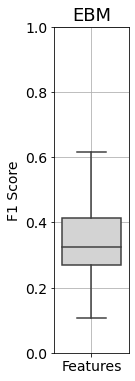

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1.33,6))
ax.set_ylim(0, 1)
sns.boxplot(data=pd.DataFrame(ebm_results), boxprops={'facecolor':'lightgray'}, ax=ax)
ax.set_xticklabels(['Features'])
ax.set_title('EBM')
ax.set_axisbelow(True)
ax.set_ylabel('F1 Score')
ax.grid()

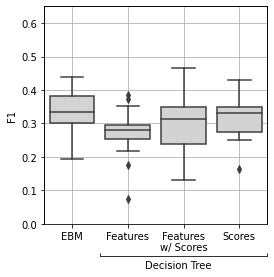

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_ylim(0, 0.65)
sns.boxplot(data=pd.DataFrame(dt_result), boxprops={'facecolor':'lightgray'}, ax=ax)
ax.set_xticklabels(['EBM', 'Features', 'Features\nw/ Scores', 'Scores'])
#ax.set_title('Decision Tree')
ax.set_ylabel('F1')
ax.set_axisbelow(True)
ax.grid()

ax2 = ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.25, 1.0])
ax2.spines['bottom'].set_bounds((0.25, 1.0))
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([0.6, 0.8]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter(['Decision Tree']))

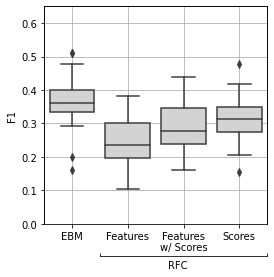

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_ylim(0, 0.65)
sns.boxplot(data=pd.DataFrame(rfc_result), boxprops={'facecolor':'lightgray'}, ax=ax)
ax.set_xticklabels(['EBM', 'Features', 'Features\nw/ Scores', 'Scores'])
ax.set_ylabel('F1')
#ax.set_title('RFC')
ax.set_axisbelow(True)
ax.grid()

ax2 = ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.25, 1.0])
ax2.spines['bottom'].set_bounds((0.25, 1.0))
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([0.6, 0.8]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter(['RFC']))

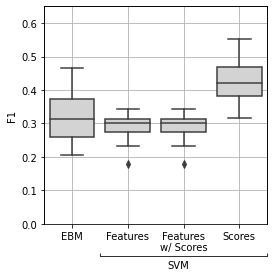

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_ylim(0, 0.65)
sns.boxplot(data=pd.DataFrame(svm_result), boxprops={'facecolor':'lightgray'}, ax=ax)
ax.set_xticklabels(['EBM', 'Features', 'Features\nw/ Scores', 'Scores'])
ax.set_ylabel('F1')
#ax.set_title('SVM')
ax.set_axisbelow(True)
ax.grid()

ax2 = ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.25, 1.0])
ax2.spines['bottom'].set_bounds((0.25, 1.0))
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([0.6, 0.8]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter(['SVM']))

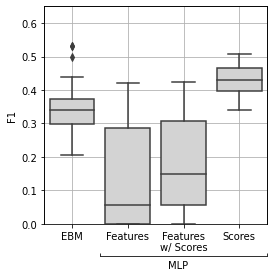

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.set_ylim(0, 0.65)
sns.boxplot(data=pd.DataFrame(mlp_result), boxprops={'facecolor':'lightgray'}, ax=ax)
ax.set_xticklabels(['EBM', 'Features', 'Features\nw/ Scores', 'Scores'])
ax.set_ylabel('F1')
#ax.set_title('MLP')
ax.set_axisbelow(True)
ax.grid()

ax2 = ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.15))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

ax2.set_xticks([0.25, 1.0])
ax2.spines['bottom'].set_bounds((0.25, 1.0))
ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([0.6, 0.8]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter(['MLP']))

0.34094447327452

In [ ]:
np.mean(mlp_result['s']) - np.mean(mlp_result['ebm'])

0.07499502333507907

In [ ]:
np.mean(svm_result['s']) - np.mean(svm_result['ebm'])

0.10674580513934595